In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import KFold
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers.normalization import BatchNormalization
from sklearn.metrics import mean_squared_error
import sys
from keras import regularizers
from keras.callbacks import EarlyStopping
from sklearn.model_selection import GridSearchCV

pd.set_option('display.max_columns', 500)
%matplotlib inline

C:\Continuum\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using TensorFlow backend.


### Checking Device Status

In [4]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/cpu:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12871277050553692567
, name: "/gpu:0"
device_type: "GPU"
memory_limit: 3889909760
locality {
  bus_id: 1
}
incarnation: 11145038728143388022
physical_device_desc: "device: 0, name: Quadro M2000M, pci bus id: 0000:01:00.0"
]


## Introduction

This notebook majorly based on Neural Network models and is based on Tensorflow wit Keras in the front-end. To train and test neural net models we will use Keras modules, as it is a simple & high-level model definition interface that fully supports pure TensorFlow libraries.

### Design and Methodology

The design is very similar to XGBoost design. In this project, we start with a simple Multi Layer Perceptron(MLP) that provides a base score to improve and build upon. Further, we add more layers to the base model and try to tweak various hyperparameters to get better results

The methodology planned is a follows:

- Step 0: Basic data processing, encode categorical variables and impute the missing values so that the data is ready for building a MLP.
- Step 1. Define a basic neural network configuration, train it, get a score which will be used as the lower margin of MLP performance.
- Step 2. Discuss the performance of a 2-layer model in context of bias-variance tradeoff and common issues: overfitting, instability due to high variance.
- Step 3. Define a 3-layer model. Show the potential overfitting issues. Introduce cross-validation to prevent overfitting.
- Step 4. Introduce GridSearchCV to test hyperparameters space and find out which are more robust.
- Step 5. After several rounds of GridSearch, define and train the best model, cross-validate the results.

In [5]:
# importing train and test datasets
train=pd.read_csv("input/train_fe.csv")
test=pd.read_csv("input/test_fe.csv")

cols = train.columns
train.shape, test.shape

((30119, 299), (7662, 298))

In [6]:
def corr_features():

    excluded_var={
        "young_male", "school_education_centers_top_20_raion", "0_17_female", 
        "railroad_1line", "7_14_female", "0_17_all", "children_school","ecology",
        "16_29_male", "mosque_count_3000", "female_f", "church_count_1000",
        "railroad_terminal_raion","mosque_count_5000", "big_road1_1line", "mosque_count_1000",
        "7_14_male", "0_6_female", "oil_chemistry_raion","young_all", "0_17_male", "ID_bus_terminal",
        "university_top_20_raion", "mosque_count_500","ID_big_road1","ID_railroad_terminal",
        "ID_railroad_station_walk", "ID_big_road2", "ID_metro", "ID_railroad_station_avto",
        "0_13_all", "mosque_count_2000", "work_male", "16_29_all", "young_female", "work_female",
        "0_13_female","ekder_female", "7_14_all", "big_church_count_500","leisure_count_500", 
        "cafe_sum_1500_max_price_avg", "leisure_count_2000","office_count_500", "male_f",
        "nuclear_reactor_raion", "0_6_male", "church_count_500", "build_count_before_1920",
        "thermal_power_plant_raion", "cafe_count_2000_na_price", "cafe_count_500_price_high",
        "market_count_2000", "trc_count_500", "market_count_1000",
        "work_all", "additional_education_raion","build_count_slag", "leisure_count_1000", "0_13_male",
        "office_raion","raion_build_count_with_builddate_info", "market_count_3000", "ekder_all",
        "trc_count_1000", "build_count_1946-1970","office_count_1500", "cafe_count_1500_na_price",
        "big_church_count_5000", "big_church_count_1000", "build_count_foam","church_count_1500",
        "church_count_3000", "leisure_count_1500","16_29_female", "build_count_after_1995", 
        "cafe_avg_price_1500", "office_sqm_1000", "cafe_avg_price_5000", "cafe_avg_price_2000",
        "big_church_count_1500", "full_all", "cafe_sum_5000_min_price_avg","office_sqm_2000",
        "church_count_5000","0_6_all", "detention_facility_raion", "cafe_avg_price_3000","young_male",
        "school_education_centers_top_20_raion", "0_17_female", "railroad_1line", "7_14_female", "0_17_all",
        "children_school","ecology", "16_29_male", "mosque_count_3000", "female_f", "church_count_1000",
        "railroad_terminal_raion","mosque_count_5000", "big_road1_1line", "mosque_count_1000", "7_14_male", 
        "0_6_female", "oil_chemistry_raion","young_all", "0_17_male", "ID_bus_terminal", "university_top_20_raion",
        "mosque_count_500","ID_big_road1","ID_railroad_terminal", "ID_railroad_station_walk", "ID_big_road2",
        "ID_metro", "ID_railroad_station_avto","0_13_all", "mosque_count_2000", "work_male", "16_29_all",
        "young_female", "work_female", "0_13_female","ekder_female", "7_14_all", "big_church_count_500",
        "leisure_count_500", "cafe_sum_1500_max_price_avg", "leisure_count_2000","office_count_500",
        "male_f", "nuclear_reactor_raion", "0_6_male", "church_count_500", "build_count_before_1920",
        "thermal_power_plant_raion", "cafe_count_2000_na_price", "cafe_count_500_price_high","market_count_2000",
        "trc_count_500", "market_count_1000", "work_all", "additional_education_raion",
        "build_count_slag", "leisure_count_1000", "0_13_male", "office_raion","raion_build_count_with_builddate_info",
        "market_count_3000", "ekder_all", "trc_count_1000", "build_count_1946-1970","office_count_1500",
        "cafe_count_1500_na_price", "big_church_count_5000", "big_church_count_1000", "build_count_foam",
        "church_count_1500", "church_count_3000", "leisure_count_1500","16_29_female", "build_count_after_1995",
        "cafe_avg_price_1500", "office_sqm_1000", "cafe_avg_price_5000", "cafe_avg_price_2000","big_church_count_1500",
        "full_all", "cafe_sum_5000_min_price_avg","office_sqm_2000", "church_count_5000","0_6_all",
        "detention_facility_raion", "cafe_avg_price_3000"
    }
    return excluded_var

var_drop = corr_features()

In [7]:
for var in var_drop:
    train.drop([var],axis=1,inplace=True)
    test.drop([var],axis=1,inplace=True)
    
train.shape, test.shape

((30119, 211), (7662, 210))

## 0. Data Preprocessing:

In this step, we use the train and test data which is not clean and process the data to make it fit for analysis. There are two main steps involved in preprocessing:

- First, convert all missing data into meaning data.
- Second, encode all the categorical variables.
- Third, normalize target variable: price_doc
- Standardize the features by suitable scaling

<p>It has been seen that train and test data are similar with an of exception of former having price_doc (target variable). Just for convinence I will merge both the sets so that all preprocessing tasks can be done once. To identify train and test, the are marked with 1 and 0 respectively
<p/>

In [8]:
# marking train and test sets
n=train.shape[0]
train['data_set']=1
test['data_set']=0
test.price_doc=np.nan
ids=test['id']
#logarithmic transformation of target gave better results
train.price_doc=(train.price_doc)
target=train.price_doc
train=train.append(test)
train.drop(['id'],axis=1,inplace=True)
train.shape,test.shape

((37781, 211), (7662, 211))

In [9]:
# listing down binary features
binary=[]
for i in train:
    if train[i].dtypes=='object':
        #print(train[i].value_counts())
        if train[i].value_counts().shape[0]==2:
            binary.append(i)
binary

['big_market_raion',
 'culture_objects_top_25',
 'incineration_raion',
 'radiation_raion',
 'water_1line']

In [10]:
# converting categorical varibales and handling missing data 
for i in binary:
    train[i]=pd.factorize(train[i])[0]
'''train.loc[train['ecology']=='no data','ecology_dat']=0
train.loc[train['ecology']!='no data','ecology_dat']=1
train.loc[train['ecology']=='no data','ecology']=np.nan
train.loc[train['ecology']=='poor','ecology']=1
train.loc[train['ecology']=='satisfactory','ecology']=2
train.loc[train['ecology']=='good','ecology']=3
train.loc[train['ecology']=='excellent','ecology']=4
train.ecology=pd.to_numeric(train.ecology)'''
train=pd.concat([train,pd.get_dummies(train.sub_area)],axis=1)

a=train.describe()
for i in a:
    train[i]=train[i].fillna((a.loc['min',i]-a.loc['max',i]*2))
    
train.drop(['timestamp','sub_area'],inplace=True,axis=1)

#from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
cols=train.columns.tolist()

train = pd.DataFrame(scaler.fit_transform(train), columns=cols)
"""
for i in train:    
    train[i]=train[i]/(train[i].max()-train[i].min())

"""
# separating train and test after preprocessing

test=train[train['data_set']==0]
train=train[train['data_set']==1]
print(test.shape,train.shape,n)
test.drop(['data_set','price_doc',],inplace=True,axis=1)
train.drop(['data_set','price_doc'],inplace=True,axis=1)


(7662, 355) (30119, 355) 30119


## 1. Basic 2-layer Model

In [21]:
# mlp_v1
model = Sequential()
model.add(Dense(64, input_dim=train.shape[1]))
model.add(Activation('relu'))
model.add(Dense(1))

In [22]:
model.compile(loss = 'mean_squared_error', optimizer = 'adam')

fit = model.fit(train.as_matrix(),target.as_matrix() , batch_size=32, 
              epochs=50, verbose=1,validation_split=0.3)
hist = fit.history

Train on 21329 samples, validate on 9142 samples
Epoch 1/50
21329/21329 [==============================] - 5s - loss: 67056140677621.0234 - val_loss: 88761584438020.8750
Epoch 2/50
21329/21329 [==============================] - 3s - loss: 66997898430690.5078 - val_loss: 88662573721654.2188
Epoch 3/50
21329/21329 [==============================] - 3s - loss: 66891523540382.7656 - val_loss: 88513143560438.8750
Epoch 4/50
21329/21329 [==============================] - 3s - loss: 66745348475249.3906 - val_loss: 88320493055558.2344
Epoch 5/50
21329/21329 [==============================] - 3s - loss: 66565273424415.6641 - val_loss: 88090283906297.3281
Epoch 6/50
21329/21329 [==============================] - 3s - loss: 66354953175268.1406 - val_loss: 87826460276110.0781
Epoch 7/50
21329/21329 [==============================] - 3s - loss: 66116753378976.7656 - val_loss: 87530488466514.2188
Epoch 8/50
21329/21329 [==============================] - 3s - loss: 65851787999539.3516 - val_loss: 872

In [28]:
# save the models into a dictionary
models_history = {}
models_history['mlp_v1'] = hist

In [29]:
def mse2rmse(history):
    history['loss'] = list(np.array(history['loss'])**0.5)
    history['val_loss'] = list(np.array(history['val_loss'])**0.5)

In [30]:
mse2rmse(models_history['mlp_v1'])

In [31]:
def plot_mlp_loss(history,title):
    
    mlp_epochs = len(hist['val_loss'])
   
    if mlp_epochs>=20:
        fig,(ax1,ax2) = plt.subplots(figsize = (16,6),ncols=2)
        ax1.set_title('{} after {} epochs'.format(title,mlp_epochs))
        ax1.set_xlabel('epochs')
        ax1.set_ylabel('loss')
        ax1.plot(history['loss'], label = 'Training loss')
        ax1.plot(history['val_loss'], label = 'Validation loss')
        ax1.grid(True)
        ax1.legend()
        # last 20 epochs
        ax2.set_title('{} during {} epochs'.format(title,'last 20'))
        ax2.set_xlabel('epochs')
        ax2.set_ylabel('loss')
        ax2.plot(history['loss'][-20:], label = 'Training loss')
        ax2.plot(history['val_loss'][-20:], label = 'Validation loss')
        ax2.set_xticklabels(range((mlp_epochs-20),mlp_epochs))
        ax2.grid(True)
        ax2.legend()
    else:
        fig,ax1 = plt.subplots(figsize = (16,6))
        ax1.set_title('{} after {} epochs'.format(title,mlp_epochs))
        ax1.set_xlabel('epochs')
        ax1.set_ylabel('loss')
        ax1.plot(history['loss'], label = 'Training loss')
        ax1.plot(history['val_loss'], label = 'Validation loss')
        ax1.grid(True)
        ax1.legend()

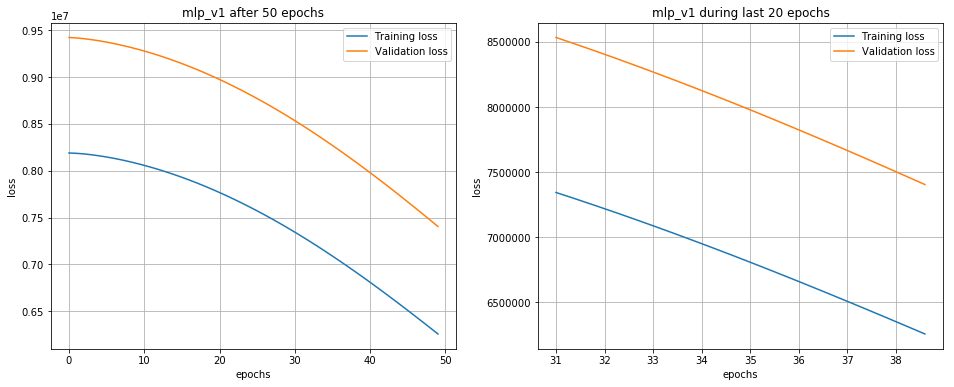

In [27]:
plot_mlp_loss(models_history['mlp_v1'], 'mlp_v1')

## Step 2: Performance of a 2-layer MLP

### Increasing the batch size

In [28]:
# mlp_v2
model = Sequential()
model.add(Dense(64, input_dim=train.shape[1]))
model.add(Activation('relu'))
model.add(Dense(1))

In [29]:
# mlp_v2
model.compile(loss = 'mean_squared_error', optimizer = 'adam')

fit = model.fit(train.as_matrix(),target.as_matrix() , batch_size=64, 
              epochs=50, verbose=1,validation_split=0.3)
hist = fit.history

Train on 21329 samples, validate on 9142 samples
Epoch 1/50
21329/21329 [==============================] - 1s - loss: 67063110683084.0312 - val_loss: 88785857615764.0156
Epoch 2/50
21329/21329 [==============================] - 1s - loss: 67043920569672.3438 - val_loss: 88752398022198.5469
Epoch 3/50
21329/21329 [==============================] - 1s - loss: 67006817693561.0000 - val_loss: 88698895649211.1094
Epoch 4/50
21329/21329 [==============================] - 1s - loss: 66953704098362.6484 - val_loss: 88627714366529.1875
Epoch 5/50
21329/21329 [==============================] - 1s - loss: 66886269057957.4062 - val_loss: 88540457796687.9688
Epoch 6/50
21329/21329 [==============================] - 1s - loss: 66805858522119.4375 - val_loss: 88438644169459.8438
Epoch 7/50
21329/21329 [==============================] - 1s - loss: 66713524035446.1172 - val_loss: 88323439031550.7188
Epoch 8/50
21329/21329 [==============================] - 1s - loss: 66610141191000.2109 - val_loss: 881

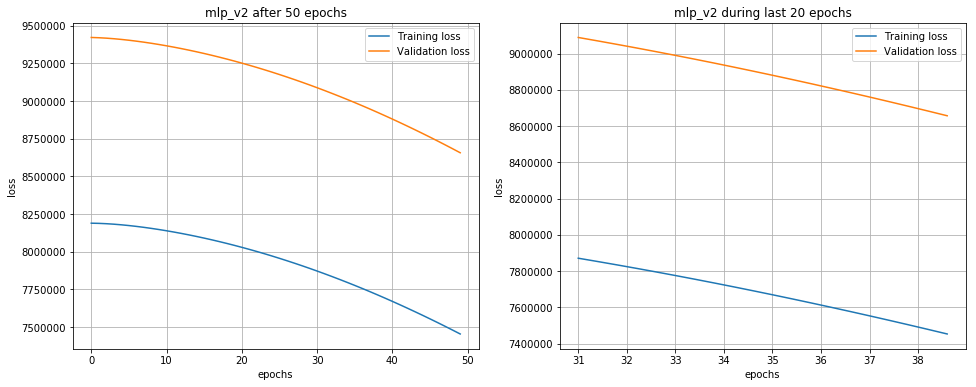

In [30]:
models_history['mlp_v2'] = hist

mse2rmse(models_history['mlp_v2'])
plot_mlp_loss(history=models_history['mlp_v2'], title='mlp_v2')

### Increasing the number of units in the hidden layer

In [31]:
# mlp_v3
model = Sequential()
model.add(Dense(128, input_dim=train.shape[1]))
model.add(Activation('relu'))
model.add(Dense(1))

In [32]:
# mlp_v3
model.compile(loss = 'mean_squared_error', optimizer = 'adam')

fit = model.fit(train.as_matrix(),target.as_matrix() , batch_size=32, 
              epochs=50, verbose=1,validation_split=0.3)
hist = fit.history

Train on 21329 samples, validate on 9142 samples
Epoch 1/50
21329/21329 [==============================] - 3s - loss: 67044248645106.7734 - val_loss: 88719392597156.2031
Epoch 2/50
21329/21329 [==============================] - 3s - loss: 66916381177331.4453 - val_loss: 88501056002072.6406
Epoch 3/50
21329/21329 [==============================] - 3s - loss: 66680028306003.8047 - val_loss: 88168383694803.6406
Epoch 4/50
21329/21329 [==============================] - 3s - loss: 66355800590450.3672 - val_loss: 87741623332436.5625
Epoch 5/50
21329/21329 [==============================] - 3s - loss: 65958038438245.9609 - val_loss: 87234101742896.4375
Epoch 6/50
21329/21329 [==============================] - 3s - loss: 65494908023198.2344 - val_loss: 86652527386475.2500
Epoch 7/50
21329/21329 [==============================] - 3s - loss: 64971427334588.6719 - val_loss: 86002769113911.5000
Epoch 8/50
21329/21329 [==============================] - 3s - loss: 64391343508824.7578 - val_loss: 852

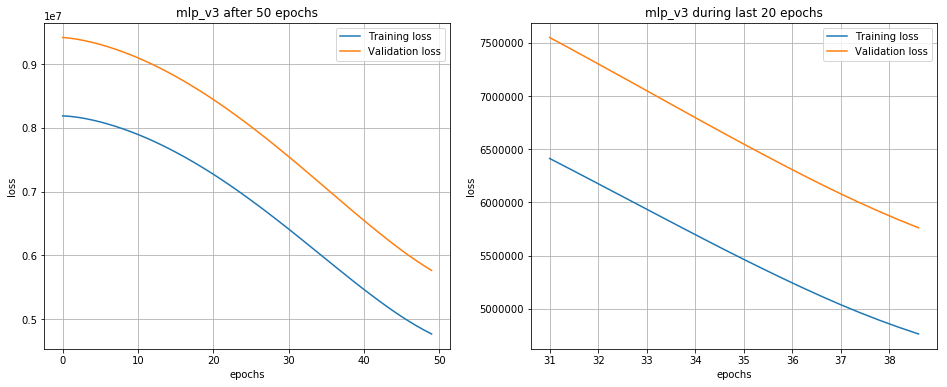

In [33]:
models_history['mlp_v3'] = hist

mse2rmse(models_history['mlp_v3'])
plot_mlp_loss(history=models_history['mlp_v3'], title='mlp_v3')

Clearly, sticking with batch size of 32 is the best and increasing the hidden units did improve a bit

### Overfitting Examination:

Chances of overfitting in Neural Networks is very easy, just by adding few layers, the model gets over fitting easily. Let us examine the same

In [34]:
train_X, test_X, train_y, test_y = train_test_split(train, target, test_size=0.3, random_state=0)
train_X.shape, train_y.shape, test_X.shape, test_y.shape

((21329, 435), (21329,), (9142, 435), (9142,))

In [35]:
# mlp_v4

model = Sequential()
model.add(Dense(128, input_dim=train_X.shape[1]))
model.add(Activation('relu'))
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dense(1))


In [36]:
# mlp_v4
model.compile(loss = 'mean_squared_error', optimizer = 'adam')

fit = model.fit(train_X.as_matrix(),train_y.as_matrix() , batch_size=32, 
              epochs=100, verbose=0,validation_data=(test_X.as_matrix(),test_y.as_matrix()))
hist = fit.history

In [37]:
models_history['mlp_v4'] = hist

mse2rmse(models_history['mlp_v4'])

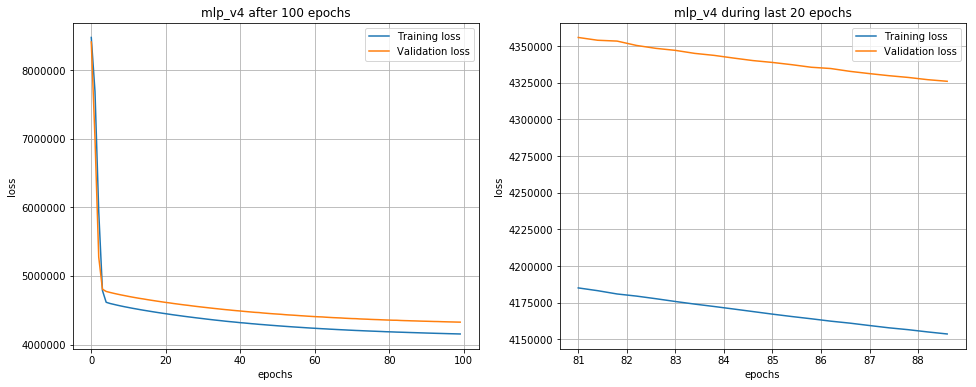

In [38]:
plot_mlp_loss(history=models_history['mlp_v4'], title='mlp_v4')

From the loss curves its evident that after 70 epochs, the validation loss wrt training loss has not improved much. On further training it might lead to overfitting the model.

batch norm, droupout

## MLP Parameter tuning


Different hyperparameter that can be use 

- Step 1: Tuning Batch Size and Number of Epochs
- Step 2: Tune Network Weight Initialization
- Step 3: Tune Dropout Regularization

### Step 1: Tuning Batch Size and Number of Epochs

The verbose output while performing grid search is exceeding large, it is advisable to pipeline it into a text file and reviewed later.

In [9]:
_stdout = sys.stdout

In [14]:
# mlp_v5
def create_model_1():
    model = Sequential()
    model.add(Dense(128, input_dim = train.shape[1]))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.3))

    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1))
    # Compile Model
    model.compile(loss = 'mean_squared_error', optimizer = 'adam')
    return model


In [15]:
%%time

my_Regressor = KerasRegressor(build_fn=create_model_1,batch_size=32, verbose=1)

# Grid Search parameters
sys.stdout = open('mlp_GrdSrhCV_1_out.txt', 'w')
validator_1 = GridSearchCV(estimator=my_Regressor,
                         param_grid={'epochs': [50, 100],
                                     'batch_size':[32, 64]},
                         n_jobs=1,
                         scoring='mean_squared_error')

grid_result_1 = validator_1.fit(train.as_matrix(), target.as_matrix())

C:\Continuum\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\metrics\scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Continuum\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\metrics\scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Continuum\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\metrics\scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Continuum\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\metrics\scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weig

In [21]:
grid_result_1.best_score_, grid_result_1.best_params_

(-7438891490492.7637, {'batch_size': 32, 'epochs': 100})

In [16]:
# summarize results

print("Best: %f using %s" % (grid_result_1.best_score_, grid_result_1.best_params_))
means = grid_result_1.cv_results_['mean_test_score']
stds = grid_result_1.cv_results_['std_test_score']
params = grid_result_1.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

### Step 2: Network Weight Initialization

In [25]:
def create_model_2(init_mode='uniform'):
    model = Sequential()
    model.add(Dense(128, input_dim = train.shape[1],init=init_mode))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dense(64))
    model.add(Activation('relu'))    
    model.add(Dense(1))
    # Compile Model
    model.compile(loss = 'mean_squared_error', optimizer = 'adam')
    return model


In [26]:
%%time

my_Regressor = KerasRegressor(build_fn=create_model_2,batch_size=32,epochs=100, verbose=0)

# Grid Search parameters

validator_2 = GridSearchCV(estimator=my_Regressor,
                         param_grid={'init_mode' : ['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 
                                                    'glorot_uniform', 'he_normal', 'he_uniform']},
                         n_jobs=1,
                         scoring='neg_mean_squared_error')

grid_result_2 = validator_2.fit(train.as_matrix(), target.as_matrix())

C:\Continuum\Anaconda3\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(128, input_dim=442, kernel_initializer="uniform")`
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Continuum\Anaconda3\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(128, input_dim=442, kernel_initializer="lecun_uniform")`
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Continuum\Anaconda3\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(128, input_dim=442, kernel_initializer="normal")`
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Continuum\Anaconda3\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(128, input_dim=442, kern

In [29]:
grid_result_2.best_score_, grid_result_2.best_params_

(-10855970303170.637, {'init_mode': 'normal'})

In [28]:
# summarize results
print("Best: %f using %s" % (grid_result_2.best_score_, grid_result_2.best_params_))
means = grid_result_2.cv_results_['mean_test_score']
stds = grid_result_2.cv_results_['std_test_score']
params = grid_result_2.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

### Step 3: Dropout Regularization

In [33]:
def create_model_3(dropout_rate=0.0):
    model = Sequential()
    model.add(Dense(128, input_dim = train.shape[1],init='normal'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(dropout_rate))

    model.add(Dense(64,init='normal'))
    model.add(Activation('relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    # Compile Model
    model.compile(loss = 'mean_squared_error', optimizer = 'adam')
    return model


In [34]:
%%time

my_Regressor = KerasRegressor(build_fn=create_model_3,batch_size=32,epochs=100, verbose=1)
sys.stdout = open('mlp_GrdSrhCV_3_out.txt', 'w')
# Grid Search parameters

validator_3 = GridSearchCV(estimator=my_Regressor,
                         param_grid={'dropout_rate': [0,0.1,0.2,0.3,0.4, 0.5,0.6,0.7,0.8,0.9]
                                    },
                         n_jobs=1,
                         scoring='neg_mean_squared_error'
                        )

grid_result_3 = validator_3.fit(train.as_matrix(), target.as_matrix())

C:\Continuum\Anaconda3\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(128, input_dim=442, kernel_initializer="normal")`
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Continuum\Anaconda3\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(64, kernel_initializer="normal")`
  


In [36]:
# summarize results
print("Best: %f using %s" % (grid_result_3.best_score_, grid_result_3.best_params_))
means = grid_result_3.cv_results_['mean_test_score']
stds = grid_result_3.cv_results_['std_test_score']
params = grid_result_3.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [2]:
from sklearn.metrics import mean_squared_error

### Validation of Grid Search Data

In [7]:
train_X, test_X, train_y, test_y = train_test_split(train, target, test_size=0.3, random_state=0)
train_X.shape, train_y.shape, test_X.shape, test_y.shape

((21083, 442), (21083,), (9036, 442), (9036,))

In [8]:
# mlp_GrdSrhCV_3_10

model = Sequential()
model.add(Dense(128, input_dim = train.shape[1],init='normal' ))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.1))

model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(Dense(1))
# Compile Model
model.compile(loss = 'mean_squared_error', optimizer = 'adam')


C:\Continuum\Anaconda3\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(128, input_dim=442, kernel_initializer="normal")`
  after removing the cwd from sys.path.


In [9]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
fit = model.fit(train_X.as_matrix(),train_y.as_matrix() , batch_size=32, 
              epochs=100, verbose=1,validation_split=0.3, callbacks=[early_stopping])
hist = fit.history
pred = model.predict(test_X.as_matrix(),batch_size=32)


Train on 14758 samples, validate on 6325 samples
Epoch 1/100
14758/14758 [==============================] - 5s - loss: 63008462876569.3047 - val_loss: 63042122280683.4766
Epoch 2/100
14758/14758 [==============================] - 3s - loss: 62807471818089.5000 - val_loss: 62635217198424.0312
Epoch 3/100
14758/14758 [==============================] - 3s - loss: 62177794062714.2969 - val_loss: 61664762739738.7109
Epoch 4/100
14758/14758 [==============================] - 3s - loss: 60944049943033.6875 - val_loss: 60145413663546.0000
Epoch 5/100
14758/14758 [==============================] - 4s - loss: 58986525139193.7891 - val_loss: 56534421721108.0859
Epoch 6/100
14758/14758 [==============================] - 3s - loss: 56279445541137.6641 - val_loss: 53701514946601.1250
Epoch 7/100
14758/14758 [==============================] - 3s - loss: 52930965757151.5547 - val_loss: 50957967679556.6484
Epoch 8/100
14758/14758 [==============================] - 3s - loss: 48941797956636.1719 - val_l

NameError: name 'mean_squared_error' is not defined

In [12]:
score = mean_squared_error(test_y, pred)
print("The final CV score is {}".format(score**.5))

The final CV score is 2695731.6847721385


In [18]:
models_history['mlp_GrdSrhCV_final'] = hist

mse2rmse(models_history['mlp_GrdSrhCV_final'])

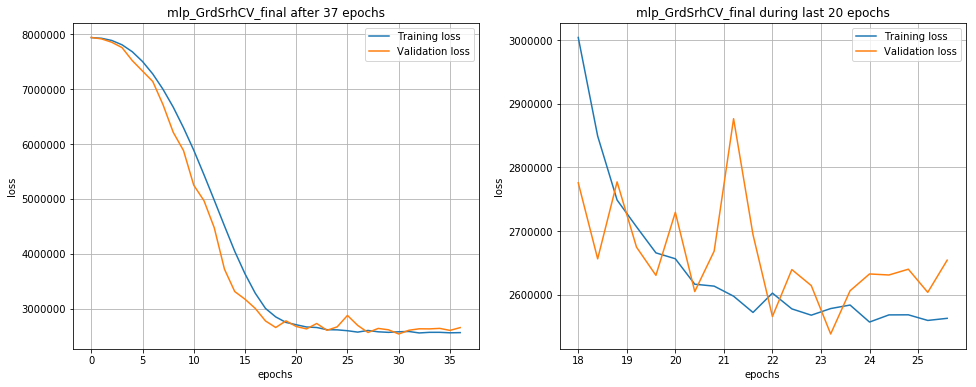

In [20]:

plot_mlp_loss(history=models_history['mlp_GrdSrhCV_final'], title='mlp_GrdSrhCV_final')

### Droppped Features Analysis

In [54]:
train_X, test_X, train_y, test_y = train_test_split(train,(target), test_size=0.3, random_state=0)
train_X.shape, train_y.shape, test_X.shape, test_y.shape

((21083, 353), (21083,), (9036, 353), (9036,))

In [55]:
# mlp_GrdSrhCV_3_10

model = Sequential()
model.add(Dense(128, input_dim = train.shape[1],init='normal' ))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.1))

model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(Dense(1))
# Compile Model
model.compile(loss = 'mean_squared_error', optimizer = 'adam')

C:\Continuum\Anaconda3\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(128, kernel_initializer="normal", input_dim=353)`
  after removing the cwd from sys.path.


In [56]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
fit = model.fit(train_X.as_matrix(),train_y.as_matrix() , batch_size=32, 
              epochs=100, verbose=1,validation_split=0.3, callbacks=[early_stopping])
hist = fit.history
pred = model.predict(test_X.as_matrix(),batch_size=32)

Train on 14758 samples, validate on 6325 samples
Epoch 1/100
14758/14758 [==============================] - 4s - loss: 63005042834039.4141 - val_loss: 63032017737492.6016
Epoch 2/100
14758/14758 [==============================] - 3s - loss: 62765172777798.1797 - val_loss: 62611391851435.9766
Epoch 3/100
14758/14758 [==============================] - 3s - loss: 62011898894395.6719 - val_loss: 60831409999884.3047
Epoch 4/100
14758/14758 [==============================] - 3s - loss: 60555114625027.0547 - val_loss: 58689243190892.2266
Epoch 5/100
14758/14758 [==============================] - 3s - loss: 58278098091061.7109 - val_loss: 55520175818843.6328
Epoch 6/100
14758/14758 [==============================] - 3s - loss: 55104085597125.5781 - val_loss: 51317144125403.7266
Epoch 7/100
14758/14758 [==============================] - 3s - loss: 51133841612379.2422 - val_loss: 46500854217583.7500
Epoch 8/100
14758/14758 [==============================] - 3s - loss: 46532924406298.1562 - val_l

In [57]:
score = mean_squared_error(test_y, pred)
print("The final CV score is {}".format(score**.5))

The final CV score is 2639784.473102742


In [58]:
models_history['mlp_GrdSrhCV_final_reduced'] = hist

mse2rmse(models_history['mlp_GrdSrhCV_final_reduced'])

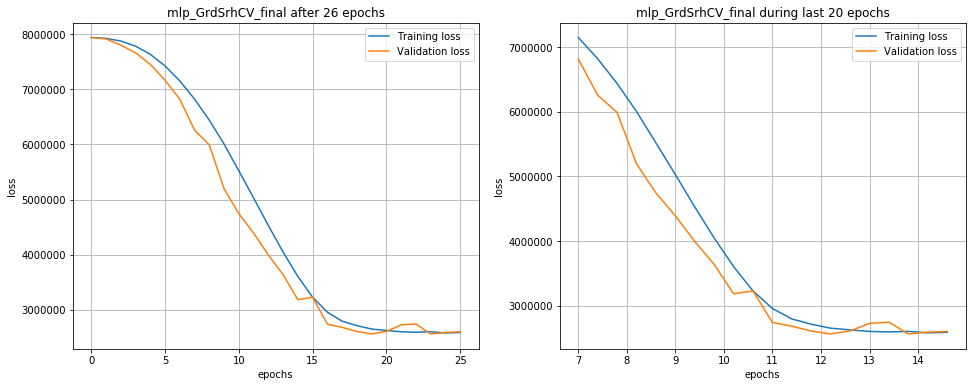

In [60]:

plot_mlp_loss(history=models_history['mlp_GrdSrhCV_final_reduced'], title='mlp_GrdSrhCV_final')